# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from thermostability.thermo_dataset import ThermostabilityDataset

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

'pynvml module not found, please install pynvml'

# Defining datasets (train/validation) 

In [2]:
trainSet = ThermostabilityDataset("data/train_sequences.fasta", max_seq_len=200, max_ds_len=200)
valSet = ThermostabilityDataset("data/eval_sequences.fasta", max_seq_len=200, max_ds_len=50)

dataloaders = {
    "train": torch.utils.data.DataLoader(trainSet, batch_size=8, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(valSet, batch_size=8, shuffle=True, num_workers=4)
}

dataset_sizes = {"train": len(trainSet),"val": len(valSet)}
print(dataset_sizes)

Loading data from cache file:  data/train_sequences.fasta_cache.p
Loading data from cache file:  data/eval_sequences.fasta_cache.p
{'train': 200, 'val': 50}


In [3]:
print(next(enumerate(dataloaders["train"])))

(0, [('MDLKQYITIVPDFPKPGIMFKDITTLMDNGPAYKYATDQIVQYAREKQIDIVVGPEARGFIIGCPVAYALGVGFAPVRKEGKLPREVVRVEYGLEYGTDVLTMHKDAIKPGQRVLITDDLLATGGTMRATIDLVEQLGGVVAGLAFLIELTELGGRKKLEGYDILTLMQF', 'MKVAEKQIEVRYAETDQMGVVYHANYLVWMEVGRTELIKQLGFHYADMEKKGIISPVVDLQVSYKKPLRYGETATVRTWIDAYDGIRVTYGYEILAPDGEVAVTGKSQHVCVKRDTFRPIVIRKYFPDWHEAYERAKR', 'MKDPRDIIKRPIITENTMNLIGQKKYTFEVDVKANKTEVKDAVEKIFGVKVAKVNIMNYKGKFKRVGRYSGYTNRRRKAIVTLTPDSKEIELFEV', 'MKHNRWASLLGLAQRAGKVVSGEELVVKEVQRGRARLVLLSQDASVNTEKKVTDKCTFYGVPLCKVPDRYVLGGAIGKDARVVVAVIDEGFARQLQTMLDRS', 'MMIRPIEVRDAENFLELCKKIDESGFMLFEPGERQTTVEQQSKSIERMLFEPNKMIFVAETENKLVGFLAVIGGDVKRNRHSANVVLEFLKTIKDRALPLNYSTKRLSGQRKLEF', 'MKEEKKILGERRRQLILQWLKESEAPLTGAELAAKTNVSRQVIVQDISLLKARNEPIIATSQGYLYLKPAEPAKTYTRTVACFHTPEQTKEELYLLVDCGVTVKDVKIEHPVYGDLTASIMVSNRLEVDQFIAKIEATKSSYLLQLTDGTHLHTLEADSPVKLDAACRALKQAGFLIEA', 'MPLHVVLYQPEIPANTGNIARTCAATDTSLHLIRPLGFSTDDKMLKRAGLDYWPYVNISYYDSLDELFARFPEGEFYFITKFGRRYYDSFDFSDTEKHIFFVFGRETTGLPKELLEANMDRCLRIPMNDKVRSLNLSNTAAILVYEALRQQRFYGLS', 'MFHPIAYRG

# Defining model 

In [4]:
from thermostability.hotinfer import HotInfer
model = HotInfer()
model.esmfold.requires_grad_(False)

model.to(device)

HotInfer(
  (esmfold): ESMFold(
    (esm): ESM2(
      (embed_tokens): Embedding(33, 2560, padding_idx=1)
      (layers): ModuleList(
        (0): TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
          (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        )
        (1): TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Lin

# Setup training

In [5]:
from tqdm.notebook import tqdm
import sys

def train_model(model, criterion,optimizer , scheduler, num_epochs=25):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())

    best_epoch_loss = sys.float_info.max
    losses = []
    batchEnumeration = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
         

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                #inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    
                    loss = criterion(outputs,labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        if not torch.isnan(loss):
                            loss.backward()
                            threshold = 10
                            for p in model.parameters():
                                if p.grad != None:
                                    if p.grad.norm() > threshold:
                                        torch.nn.utils.clip_grad_norm_(p, threshold)
                            optimizer.step()
                        if torch.isnan(loss).any():
                            print(f"Nan loss: {torch.isnan(loss)}| Loss: {loss}| inputs: {inputs}")
                        

                # statistics
                batch_size = len(inputs)
                batch_loss = loss.item() * batch_size
                losses.append(batch_loss)
                batchEnumeration.append(batchEnumeration[-1]+1 if len(batchEnumeration)>0 else 0)

                running_loss += batch_loss
               
            
                if idx % 10 == 0:
                    batch_size = len(inputs)
               
                    tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], loss: {:.6f}".format(
                        epoch,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        batch_loss / float(batch_size)
                        ), end="\r")
                    
                    
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]


            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_epoch_loss:
                best_epoch_loss = epoch_loss
                #best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_epoch_loss:4f}')
    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [6]:
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

In [7]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


# Evaluation

Infering thermostability for sample 0/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([40.4280])
Infering thermostability for sample 1/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([14.8079])
Infering thermostability for sample 2/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([52.3495])
Infering thermostability for sample 3/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([41.9459])
Infering thermostability for sample 4/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([41.8849])
Infering thermostability for sample 5/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([21.9645])
Infering thermostability for sample 6/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([41.6771])
Infering thermostability for sample 7/50...
1) any nan: False
2) any nan: False
3) any nan: False
Diff:  tensor([43.9307])
Infering thermos

(array([ 1.,  0.,  1.,  4.,  4.,  2.,  2.,  6., 16., 14.]),
 array([-7.370964  , -0.98185766,  5.4072485 , 11.796355  , 18.185461  ,
        24.574568  , 30.963675  , 37.35278   , 43.741886  , 50.130993  ,
        56.5201    ], dtype=float32),
 <BarContainer object of 10 artists>)

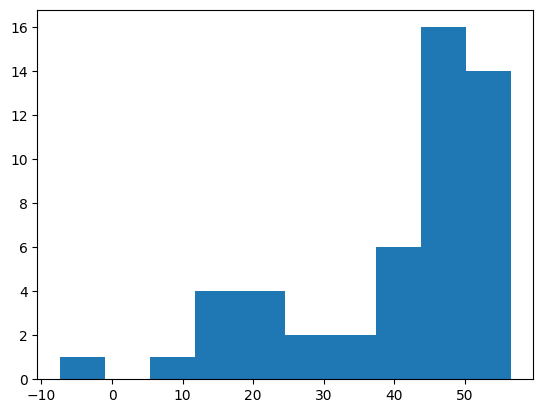

In [ ]:
def predictDiffs(set="val"):
    with torch.no_grad():
        n = len(dataloaders[set])
        diffs = torch.tensor([])
        for index, (inputs, labels) in enumerate(dataloaders[set]):
            #inputs = inputs.to(device)
            print(f"Infering thermostability for sample {index}/{n}...")
            labels = labels.to(device)
            outputs = model(inputs)

            _diffs = outputs.squeeze(1).sub(labels.squeeze(1)).cpu()
            diffs = torch.cat((diffs, _diffs))
            print("Diff: ", _diffs)
    return diffs
diffs = predictDiffs()

#diffs = np.array([0, 0.1, 0.2,-0.2, -0.8, 0.1])
plt.hist(diffs, 10)
